In [3]:
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pylab as plt
from Datasets import RefinementDataset, GTADataset
from mmseg.models.backbones.mix_transformer import MixVisionTransformer
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import glob,os
from mmcv import Config

In [4]:
cfg = Config.fromfile("configs/mic/LW4toI3_mic_hrda.py")

In [5]:
cfg.uda.source

'LW4'

In [ ]:
class DistributionDataset(Dataset):
    def __init__(self,labels_list,train_data_root="data/gta/"):
        super().__init__()
        self.labels = labels_list

        self.transform = transforms.Resize((256,256))

    def __len__(self):
        return len(self.labels)

    def open_image(self, path):
        img = Image.open(path).convert("P")
        img = self.transform(img)

        img = np.array(img)
        img.setflags(write=True)

        img = torch.tensor(img).unsqueeze(0)

        targets = torch.arange(19)
        masks = []
        true_targets = []
        for cls in targets:
            mask = (img == cls).float()
            if mask.sum() == 0:
                continue
            masks.append(mask)
            true_targets.append(cls)
        masks = torch.stack(masks)
        true_targets = torch.stack(true_targets)

        return masks,true_targets
    def __getitem__(self, index):
        gt_image  = self.open_image(self.labels[index])
        return gt_image
labels_list = glob.glob(os.path.join("data/gta","labels","*_labelTrainIds.png"),recursive=True)
training_size =int( 0.9 * len(labels_list))
train_label = labels_list[:training_size]
val_label = labels_list[training_size:]

train_ds = DistributionDataset(train_label)
val_ds = DistributionDataset(val_label)

In [23]:
transform = transforms.Resize((256,256))
img = transform(Image.open(labels_list[2]).convert("P"))
img = np.array(img)
gt = torch.tensor(img)

In [24]:
gt.unique()

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         17, 255], dtype=torch.uint8)

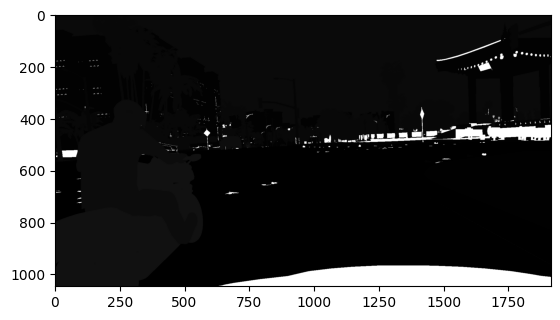

In [16]:
plt.imshow(Image.open(labels_list[2]).convert("P"))

In [31]:
train_ds[2][0][0].unique()

tensor([0., 1.])

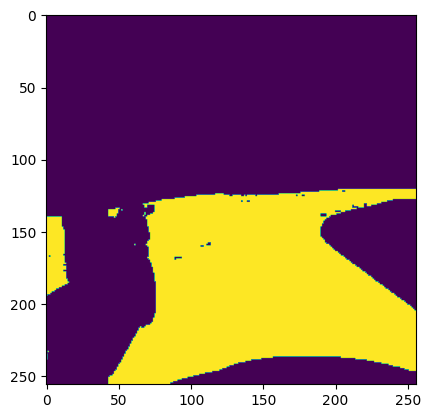

In [30]:
plt.imshow(train_ds[2][0][0].squeeze())

In [3]:
def collate_fn(data):
    masks,true_labels = zip(*data)
    return torch.cat(masks),torch.cat(true_labels)

In [4]:
dataloader = DataLoader(train_ds,batch_size=8,collate_fn=collate_fn)

In [5]:
masks,true_labels = next(iter(dataloader))

In [6]:
masks.shape

torch.Size([105, 1, 256, 256])

In [7]:
model = BinaryMaskTransformer()

In [9]:
out = model(masks)

torch.Size([105, 512, 17, 17])
64
